# Policy gradient avec CartPole de Gym 📌

Autheur : Leffe Pierre

École : Ynov


## Introduction ✍🏽

CartPole est un jeu où vous devez garder un bâton en équilibre sur une plateforme en déplaçant un chariot de gauche à droite. Le chariot a deux boutons, un pour aller à gauche et l'autre pour aller à droite. Le but est de maintenir le bâton en équilibre le plus longtemps possible pour gagner des points. Si le bâton penche trop ou si le chariot sort de la zone de jeu, le jeu est perdu.



# Élaboration du Policy gradient

ℹ️ Les fonctions et les classes suivante sont créer pour pouvoir par la suite changer les hyperparmetres ajustable pour plus tard utiliser optuna.
Dans cette partie les hyperparamète seront ceux choisis par défaut dans les classes.


## Policy DL

Nous créons un premier réseaux de neuronnes qui aura pour but d'ajuster les probabilité de choix des actions.

In [10]:
import torch
import torch.nn as nn
from typing import List

class Policy(nn.Module):
    """
    Classe qui crée un réseau de neurones pour la prise de décision.

    Attributes
    ----------
    state_space_size : int
        Nombre de paramètres en entrée du réseau.
    action_space_size : int
        Nombre de paramètres en sortie du réseau.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor:
        Calcule la sortie du réseau de neurones.

    """
    def __init__(self, state_space_size: int = 4, action_space_size: int = 2, neural_network: nn.Module = None) -> None:
        """
        Initialise un réseau de neurones pour la prise de décision.

        Parameters
        ----------
        state_space_size : int
            Nombre de paramètres en entrée du réseau.
        action_space_size : int
            Nombre de paramètres en sortie du réseau.

        """
        super(Policy, self).__init__()
        
        if neural_network==None:
            self.fc1 = nn.Linear(state_space_size, 128)
            self.fc2 = nn.Linear(128, 64)
            self.fc3 = nn.Linear(64, 64)
            self.fc4 = nn.Linear(64, action_space_size)
            self.neural_network=None
        else:
            self.neural_network = neural_network

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Calcule la sortie du réseau de neurones.

        Parameters
        ----------
        x : torch.Tensor
            Les données d'entrée du réseau.

        Returns
        -------
        torch.Tensor
            La probabilité de chaque action possible.

        """
        if self.neural_network==None:
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.relu(self.fc3(x))
            x = self.fc4(x)
            return torch.softmax(x, dim=-1)
        else:
            return torch.softmax(self.neural_network(x), dim=-1)



## Création de la classe Policy   

In [31]:
import numpy as np
import torch
import torch.optim as optim
import gymnasium as gym

class PolicyGradientAgent:
    def __init__(self, state_space_size: int=4, action_space_size: int=2,neural_network:List[nn.Linear]=None,lr:float=0.001,gamma=0.99):
        """
        Initialise un agent de gradient de politique.

        Args:
        - state_space_size (int) : taille de l'espace d'état
        - action_space_size (int) : taille de l'espace d'action
        """
        if neural_network==None :
            self.neural_network = Policy(state_space_size, action_space_size)
            self.policy = Policy(state_space_size, action_space_size)
        else:
            self.neural_network=None
            self.policy=Policy()
        self.learning_rate=lr
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps = np.finfo(np.float32).eps.item()

        self.rewards = []
        self.log_probs = []

    def pick_action(self, state) -> int:
        """
        Choisi une action à partir de l'état donné.

        Args:
        - state (np.ndarray) : état actuel de l'environnement

        Returns:
        - action (int) : action sélectionnée par l'agent
        """
        if isinstance(state, tuple):
            state = torch.from_numpy(state[0]).float().unsqueeze(0)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy(state)
        m = torch.distributions.Categorical(probs)
        action = m.sample()
        self.log_probs.append(m.log_prob(action))
        return action.item()

    def play_episode(self, environment: gym.Env) -> float:
        """
        Joue un épisode complet de notre environnement.

        Args:
        - environment (gym.Env) : environnement dans lequel l'agent évolue

        Returns:
        - episode_reward (float) : récompense totale pour l'épisode
        """
        state = environment.reset()
        done = False
        episode_reward = 0

        while not done:
            action = self.pick_action(state)
            state, reward, done, info, _ = environment.step(action)
            self.rewards.append(reward)
            episode_reward += reward
            if episode_reward >= 500:
                done = True
            
        return episode_reward

    def train_agent(self):
        """
        Entraîne l'agent sur les épisodes précédents.
        """
        discounts = [self.gamma**i for i in range(len(self.rewards))]
        rewards = torch.tensor(self.rewards)
        discounts = torch.tensor(discounts)
        discounts = discounts.float().unsqueeze(1)
        rewards = rewards.float().unsqueeze(1)

        discounted_rewards = discounts * rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + self.eps)

        policy_loss = []
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            policy_loss.append(-log_prob * reward)
        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.rewards = []
        self.log_probs = []


In [12]:
from typing import List

def run_policy_gradient_agent(agent,num_episodes: int, state_space_size: int, action_space_size: int,log: bool = True,ag_re:bool=False) -> List[float]:
    env = gym.make('CartPole-v1')

    rewards_history = []
    count_score_max = 0
    i = 0
    while i < num_episodes and count_score_max < 10:
        episode_reward = agent.play_episode(env)
        agent.train_agent()
        rewards_history.append(episode_reward)

        if(log):
            print('Episode {}: reward = {}'.format(i, episode_reward))
        if episode_reward == 500:
            count_score_max+=1
        else:
            count_score_max=0
        i+=1

    env.close()
    if ag_re==True:
        return rewards_history, agent
    return rewards_history


In [13]:
agent = PolicyGradientAgent(state_space_size=4, action_space_size=2)

rewards_history,agent = run_policy_gradient_agent(agent,num_episodes=1000, state_space_size=4, action_space_size=2,ag_re=True)


Episode 0: reward = 13.0
Episode 1: reward = 16.0
Episode 2: reward = 13.0
Episode 3: reward = 33.0
Episode 4: reward = 18.0
Episode 5: reward = 18.0
Episode 6: reward = 22.0
Episode 7: reward = 19.0
Episode 8: reward = 24.0
Episode 9: reward = 31.0
Episode 10: reward = 20.0
Episode 11: reward = 23.0
Episode 12: reward = 31.0
Episode 13: reward = 15.0
Episode 14: reward = 20.0
Episode 15: reward = 14.0
Episode 16: reward = 12.0
Episode 17: reward = 24.0
Episode 18: reward = 20.0
Episode 19: reward = 16.0
Episode 20: reward = 11.0
Episode 21: reward = 14.0
Episode 22: reward = 21.0
Episode 23: reward = 72.0
Episode 24: reward = 26.0
Episode 25: reward = 49.0
Episode 26: reward = 32.0
Episode 27: reward = 46.0
Episode 28: reward = 18.0
Episode 29: reward = 18.0
Episode 30: reward = 25.0
Episode 31: reward = 35.0
Episode 32: reward = 14.0
Episode 33: reward = 28.0
Episode 34: reward = 13.0
Episode 35: reward = 20.0
Episode 36: reward = 26.0
Episode 37: reward = 21.0
Episode 38: reward = 1

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Définition de la fonction pour calculer la moyenne mobile
def running_mean(x: np.ndarray) -> np.ndarray:
    N: int = 50
    kernel: np.ndarray = np.ones(N)
    conv_len: int = x.shape[0] - N
    y: np.ndarray = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i + N]
        y[i] /= N
    return y

    
def plot_running_mean(rewards_history: np.ndarray) -> None:
    # Création des données pour la visualisation
    score: np.ndarray = np.array(rewards_history)
    avg_score: np.ndarray = running_mean(score)

    # Configuration de la figure
    sns.set(style='darkgrid', palette='colorblind')
    plt.figure(figsize=(15, 7))

    # Ajout des titres et des axes
    plt.title('Performance du modèle au fil du temps', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Durée de la trajectoire', fontsize=12)

    # Traçage de la courbe de performance moyenne
    sns.lineplot(x=np.arange(avg_score.shape[0]), y=avg_score, color='blue', linewidth=3, label='Performance moyenne')

    # Traçage de la courbe de performance brute
    sns.lineplot(x=np.arange(score.shape[0]), y=score, color='gray', linewidth=1, label='Performance brute')

    # Traçage des points de performance bruts
    sns.scatterplot(x=np.arange(score.shape[0]), y=score, color='green', linewidth=0.3, label='Performance brute')

    # Configuration de la légende
    plt.legend(fontsize=12)

    # Affichage de la figure
    plt.show()
    return score.mean()

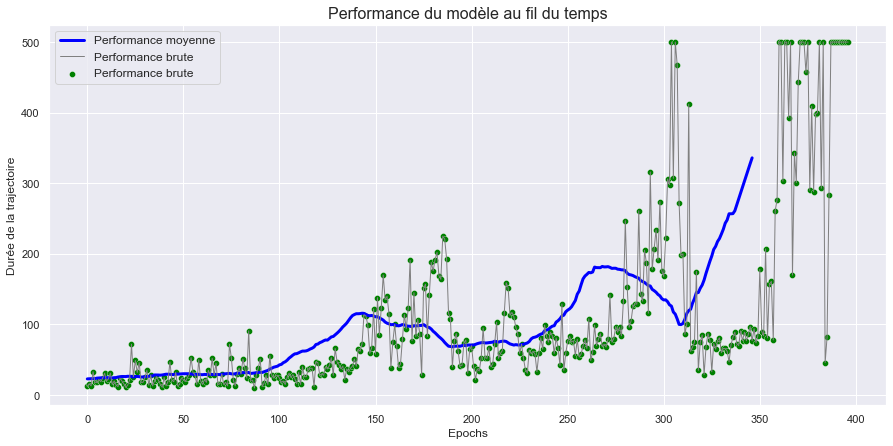

109.83123425692695

In [22]:
plot_running_mean(rewards_history)

---

## Optuna & recherche d'hyper paramètres 🕵🏽

Nous savons maintenant que le polcy gradient permet de répondre à l'enjeu de carplot.
Néanmoins, nous pouvons essayer d'aller plus loin en cherchant les bons hyper paramètres et analyser ceux qui influent le plus sur l'apprentissage de note modèle.

`Optuna` est idéale dans ces cas la puisqu'il permet de jouer en boucle le choix des hyper paramètres sur une plage donnée et l'apprentissage du modele. 
Tout en stockant les résultats et en créant des visuel afin de les interpreter.  

> Vous pouvez fermer les résultats de la sortie suivante car elle flood beaucoup ! Je les ai laisser car ça m'a permis de visualiser la courbe d'apprentissage et d'ajuster les premières fois les ranges de mes hyperparametres. 

[I 2023-03-12 12:53:57,574] Using an existing study with name '3 adjust gamma and lr' instead of creating a new one.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 17.0
Episode 1: reward = 22.0
Episode 2: reward = 10.0
Episode 3: reward = 67.0
Episode 4: reward = 18.0
Episode 5: reward = 13.0
Episode 6: reward = 35.0
Episode 7: reward = 22.0
Episode 8: reward = 18.0
Episode 9: reward = 17.0
Episode 10: reward = 20.0
Episode 11: reward = 13.0
Episode 12: reward = 23.0
Episode 13: reward = 11.0
Episode 14: reward = 17.0
Episode 15: reward = 12.0
Episode 16: reward = 30.0
Episode 17: reward = 26.0
Episode 18: reward = 14.0
Episode 19: reward = 12.0
Episode 20: reward = 13.0
Episode 21: reward = 27.0
Episode 22: reward = 64.0
Episode 23: reward = 15.0
Episode 24: reward = 15.0
Episode 25: reward = 13.0
Episode 26: reward = 31.0
Episode 27: reward = 29.0
Episode 28: reward = 22.0
Episode 29: reward = 41.0
Episode 30: reward = 54.0
Episode 31: reward = 14.0
Episode 32: reward = 14.0
Episode 33: reward = 18.0
Episode 34: reward = 14.0
Episode 35: reward = 51.0
Episode 36: reward = 18.0
Episode 37: reward = 26.0
Episode 38: reward = 1

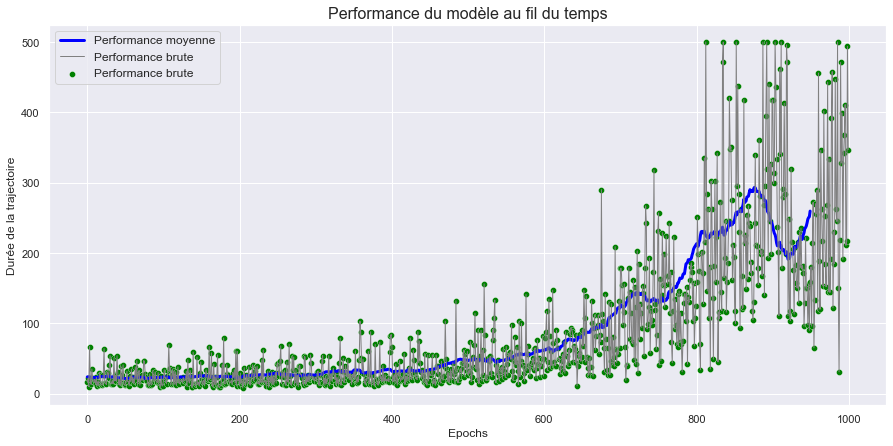

[I 2023-03-12 12:54:56,265] Trial 67 finished with value: 86.41 and parameters: {'n_layers': 1, 'n_units': 17, 'learning_rate': 0.0001435280438812114, 'gamma': 0.9980367411123942}. Best is trial 59 with value: 246.7212918660287.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 55.0
Episode 1: reward = 31.0
Episode 2: reward = 15.0
Episode 3: reward = 18.0
Episode 4: reward = 23.0
Episode 5: reward = 14.0
Episode 6: reward = 17.0
Episode 7: reward = 12.0
Episode 8: reward = 13.0
Episode 9: reward = 13.0
Episode 10: reward = 31.0
Episode 11: reward = 14.0
Episode 12: reward = 17.0
Episode 13: reward = 15.0
Episode 14: reward = 22.0
Episode 15: reward = 27.0
Episode 16: reward = 15.0
Episode 17: reward = 45.0
Episode 18: reward = 12.0
Episode 19: reward = 15.0
Episode 20: reward = 25.0
Episode 21: reward = 55.0
Episode 22: reward = 23.0
Episode 23: reward = 24.0
Episode 24: reward = 26.0
Episode 25: reward = 11.0
Episode 26: reward = 13.0
Episode 27: reward = 14.0
Episode 28: reward = 41.0
Episode 29: reward = 36.0
Episode 30: reward = 16.0
Episode 31: reward = 29.0
Episode 32: reward = 23.0
Episode 33: reward = 27.0
Episode 34: reward = 23.0
Episode 35: reward = 48.0
Episode 36: reward = 19.0
Episode 37: reward = 31.0
Episode 38: reward = 1

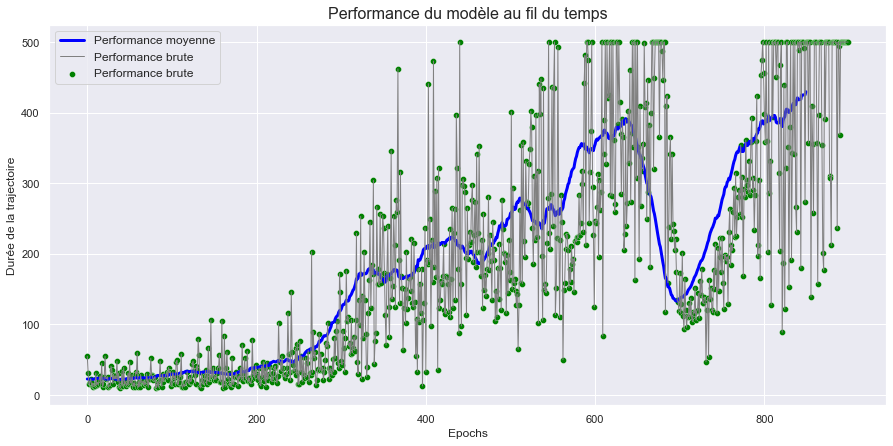

[I 2023-03-12 12:56:51,167] Trial 68 finished with value: 186.16 and parameters: {'n_layers': 1, 'n_units': 16, 'learning_rate': 0.0002447629080639726, 'gamma': 0.9998856131239705}. Best is trial 59 with value: 246.7212918660287.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 17.0
Episode 1: reward = 12.0
Episode 2: reward = 15.0
Episode 3: reward = 27.0
Episode 4: reward = 20.0
Episode 5: reward = 12.0
Episode 6: reward = 12.0
Episode 7: reward = 27.0
Episode 8: reward = 11.0
Episode 9: reward = 13.0
Episode 10: reward = 37.0
Episode 11: reward = 30.0
Episode 12: reward = 56.0
Episode 13: reward = 24.0
Episode 14: reward = 21.0
Episode 15: reward = 14.0
Episode 16: reward = 27.0
Episode 17: reward = 25.0
Episode 18: reward = 42.0
Episode 19: reward = 12.0
Episode 20: reward = 22.0
Episode 21: reward = 21.0
Episode 22: reward = 16.0
Episode 23: reward = 18.0
Episode 24: reward = 17.0
Episode 25: reward = 46.0
Episode 26: reward = 16.0
Episode 27: reward = 26.0
Episode 28: reward = 11.0
Episode 29: reward = 15.0
Episode 30: reward = 15.0
Episode 31: reward = 20.0
Episode 32: reward = 30.0
Episode 33: reward = 11.0
Episode 34: reward = 16.0
Episode 35: reward = 15.0
Episode 36: reward = 12.0
Episode 37: reward = 30.0
Episode 38: reward = 2

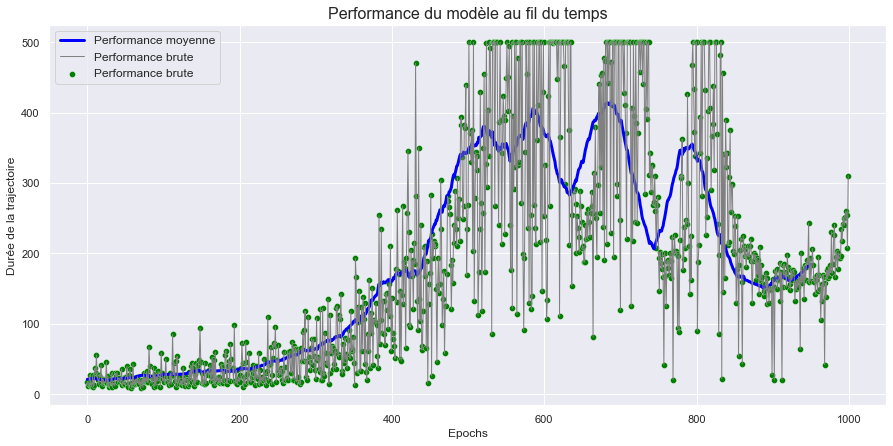

[I 2023-03-12 12:59:06,405] Trial 69 finished with value: 180.558 and parameters: {'n_layers': 1, 'n_units': 19, 'learning_rate': 0.0002397537653142007, 'gamma': 0.9817770186568705}. Best is trial 59 with value: 246.7212918660287.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 42.0
Episode 1: reward = 23.0
Episode 2: reward = 31.0
Episode 3: reward = 17.0
Episode 4: reward = 27.0
Episode 5: reward = 28.0
Episode 6: reward = 9.0
Episode 7: reward = 46.0
Episode 8: reward = 24.0
Episode 9: reward = 14.0
Episode 10: reward = 25.0
Episode 11: reward = 14.0
Episode 12: reward = 38.0
Episode 13: reward = 28.0
Episode 14: reward = 33.0
Episode 15: reward = 27.0
Episode 16: reward = 11.0
Episode 17: reward = 14.0
Episode 18: reward = 18.0
Episode 19: reward = 71.0
Episode 20: reward = 19.0
Episode 21: reward = 42.0
Episode 22: reward = 20.0
Episode 23: reward = 12.0
Episode 24: reward = 15.0
Episode 25: reward = 10.0
Episode 26: reward = 17.0
Episode 27: reward = 40.0
Episode 28: reward = 31.0
Episode 29: reward = 20.0
Episode 30: reward = 14.0
Episode 31: reward = 29.0
Episode 32: reward = 58.0
Episode 33: reward = 27.0
Episode 34: reward = 18.0
Episode 35: reward = 13.0
Episode 36: reward = 19.0
Episode 37: reward = 15.0
Episode 38: reward = 25

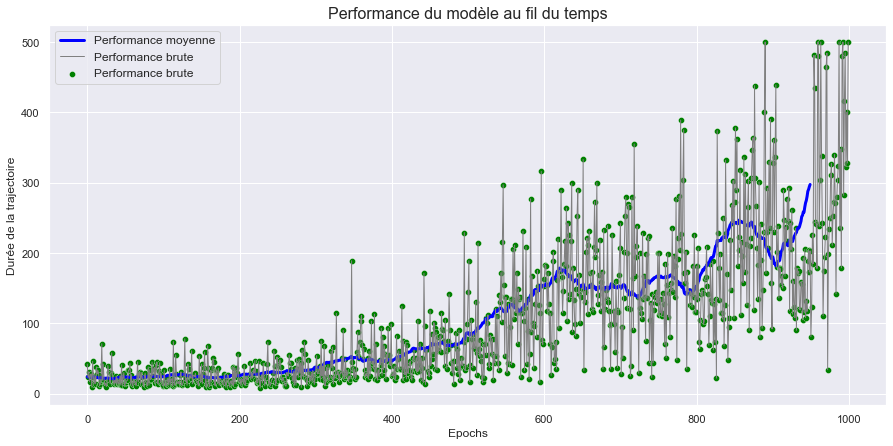

[I 2023-03-12 13:00:30,609] Trial 70 finished with value: 103.826 and parameters: {'n_layers': 1, 'n_units': 17, 'learning_rate': 0.00012770595761515887, 'gamma': 0.9908581328041982}. Best is trial 59 with value: 246.7212918660287.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 14.0
Episode 1: reward = 24.0
Episode 2: reward = 18.0
Episode 3: reward = 12.0
Episode 4: reward = 11.0
Episode 5: reward = 22.0
Episode 6: reward = 99.0
Episode 7: reward = 12.0
Episode 8: reward = 41.0
Episode 9: reward = 17.0
Episode 10: reward = 17.0
Episode 11: reward = 29.0
Episode 12: reward = 33.0
Episode 13: reward = 23.0
Episode 14: reward = 28.0
Episode 15: reward = 11.0
Episode 16: reward = 41.0
Episode 17: reward = 17.0
Episode 18: reward = 11.0
Episode 19: reward = 31.0
Episode 20: reward = 38.0
Episode 21: reward = 20.0
Episode 22: reward = 21.0
Episode 23: reward = 25.0
Episode 24: reward = 23.0
Episode 25: reward = 20.0
Episode 26: reward = 17.0
Episode 27: reward = 56.0
Episode 28: reward = 14.0
Episode 29: reward = 19.0
Episode 30: reward = 13.0
Episode 31: reward = 19.0
Episode 32: reward = 16.0
Episode 33: reward = 11.0
Episode 34: reward = 16.0
Episode 35: reward = 11.0
Episode 36: reward = 18.0
Episode 37: reward = 32.0
Episode 38: reward = 8

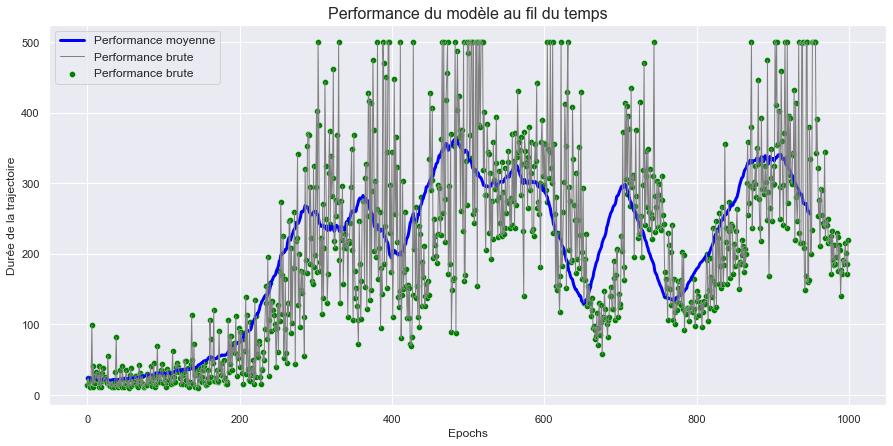

[I 2023-03-12 13:03:10,876] Trial 71 finished with value: 198.262 and parameters: {'n_layers': 1, 'n_units': 16, 'learning_rate': 0.00037202539547858, 'gamma': 0.9735571456495746}. Best is trial 59 with value: 246.7212918660287.
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
/var/folders/1k/g16n1mm56fl2nj22w_gl_jrh0000gn/T/ipykernel_6816/4143389958.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)


Episode 0: reward = 12.0
Episode 1: reward = 10.0
Episode 2: reward = 29.0
Episode 3: reward = 18.0
Episode 4: reward = 21.0
Episode 5: reward = 27.0
Episode 6: reward = 19.0
Episode 7: reward = 12.0
Episode 8: reward = 11.0
Episode 9: reward = 15.0
Episode 10: reward = 17.0
Episode 11: reward = 38.0
Episode 12: reward = 18.0
Episode 13: reward = 34.0
Episode 14: reward = 12.0
Episode 15: reward = 27.0
Episode 16: reward = 14.0
Episode 17: reward = 16.0
Episode 18: reward = 15.0
Episode 19: reward = 15.0
Episode 20: reward = 15.0
Episode 21: reward = 12.0
Episode 22: reward = 16.0
Episode 23: reward = 13.0
Episode 24: reward = 12.0
Episode 25: reward = 25.0
Episode 26: reward = 26.0
Episode 27: reward = 18.0
Episode 28: reward = 19.0
Episode 29: reward = 11.0
Episode 30: reward = 33.0
Episode 31: reward = 26.0
Episode 32: reward = 28.0
Episode 33: reward = 21.0
Episode 34: reward = 13.0
Episode 35: reward = 11.0
Episode 36: reward = 15.0
Episode 37: reward = 22.0
Episode 38: reward = 2

In [58]:

import optuna

# Définir l'espace de recherche pour optuna
def define_search_space(trial):
    # Nombre de couches cachées
    n_layers = trial.suggest_int("n_layers", 1, 3)
    # Nombre de neurones dans chaque couche cachée
    n_units = trial.suggest_int("n_units", 16, 128, log=True)
    # Créer le réseau de neurones
    layers = []
    in_features = 4 # state_space_size
    out_features = 2 # action_space_size
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    gamma = trial.suggest_loguniform('gamma', 0.8, 0.9999)
    for i in range(n_layers):
        out_features = n_units
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, out_features))

    return nn.Sequential(*layers),learning_rate,gamma

# Fonction objectif pour optuna
def objective(trial):
    # Créer un réseau de neurones avec les hyperparamètres choisis par optuna
    neural_network,learning_rate,gamma = define_search_space(trial)
    
    # Créer un agent de renforcement avec les hyperparamètres choisis par optuna
    agent = PolicyGradientAgent(neural_network=neural_network,lr=learning_rate,gamma=gamma)
    rewards_history,agent = run_policy_gradient_agent(agent,num_episodes=1000, state_space_size=4, action_space_size=2,ag_re=True)

    plot_running_mean(rewards_history)
    score: np.ndarray = np.array(rewards_history)

    loss = score
    # Retourner la perte comme métrique à minimiser par optuna
    return score.mean()

# Créer un objet Study pour optimiser les hyperparamètres
study = optuna.create_study(direction="maximize",
                            storage="sqlite:///carplot.sqlite3",  # Specify the storage URL here.
                            load_if_exists=True,
        study_name="3 adjust gamma and lr")
study.optimize(objective, n_trials=100)

# Obtenir le meilleur réseau de neurones choisi par optuna
best_neural_network = define_search_space(study.best_trial)

# Créer un objet Policy avec le meilleur réseau de neurones choisi par optuna
policy = Policy(best_neural_network)

# Utiliser l'objet Policy pour calculer les sorties du réseau
inputs = torch.randn(10, 4) # 10 exemples avec 4 paramètres en entrée
outputs = policy(inputs) # 10 probabilités de chaque action possible pour chaque exemple


# Conclusion 🏆

Poly gradient est efficace pour résoudre des problèmes d'apprentissage par renforcement. Gym nous à permis de simuler l'environnement sans s'attarder sur le développement de celui-ci et de nous concentrer sur la problématique du policy gradient.

Cependant, l'efficacité de l'algorithme dépend de la sélection appropriée des hyperparamètres. L'utilisation d'Optuna pour la recherche des hyperparamètres a permis de trouver les meilleurs paramètres pour l'algorithme, ce qui a amélioré sa performance. Optuna est donc une solution intéressante pour automatiser la recherche des hyperparamètres et pour améliorer l'efficacité de l'algorithme de Policy Gradient.

## Analyse de Optuna

| Historique des récompenses moyennes | Influence des hyper paramètres |
|:-------:|:-------:|
| ![Image générée par Optuna 1](./plot/historyv.png) | ![Image générée par Optuna 2](./plot/hyp.png) |

| Traçage des choix | Relation entre learning rate et gamma|
|:-------:|:-------:|
| ![Image générée par Optuna 3](./plot/paralle.png) | ![Image générée par Optuna 4](./plot/lr_gamma.png) |



Nous savons maintenant que le learning rate et le plus important (selon les hyperparamètres choisi et les ranges données).

Ce qui nous permet de sois, réajuster notre étude en fonction de cette analyse, soit de conserver les meilleurs hyperparamètres de celle ci.



In [6]:
study_name = '3 adjust gamma and lr'
storage_name = f'sqlite:///carplot.sqlite3'
study = optuna.load_study(study_name=study_name, storage=storage_name)

# Récupération du meilleur essai
best_trial = study.best_trial
print(f'Meilleur essai: {best_trial.number}')
print(f"Valeur des récompenses moyenne lors de l'apprentissage: {best_trial.value}")
print(f'Paramètres: {best_trial.params}')

Meilleur essai: 59
Valeur des récompenses moyenne lors de l'apprentissage: 246.7212918660287
Paramètres: {'gamma': 0.9991247504167523, 'learning_rate': 0.00027301660957697587, 'n_layers': 1, 'n_units': 19}


## Ce qui aurait pu être améliorer 

Je me suis basé sur la métrique des récompenses moyenne obtenue pour évaluer la performance du modèle néanmoins une autre métrique aurait pu être choisi plus soigneusement.
